# Tutorial for EBPCA
The EBPCA toolbox currently contains four modules for a complete EBPCA analysis--data preprocessing, pca analysis, empirical Bayes denoiser and amp iteratiave correction. The intention here is to provide a user with a working knowledge of the EBPCA method and this package.

## Section I - Fast Track

### Step 0: Model specification

Consider your data matrix $Y\in\mathbb{R}^{n\times p}$ has a low rank signal-plus-noise model, where we assue the observational noise $\mathbf{W}$ has entries $w_{ij} \overset{\textrm{i.i.d}}{=} \mathcal{N}(0,\tau^2/n)$. Before we proceed, we should note the following two properties of the data:

1. Determine the number of identifiable PCs.
2. Observe if the prior has clear non-Gaussian structure.

Suppose we have the following synthetic observation $Y$: The signal part is of rank 3, with the left PCs have a specific structure whereas the right PCs don't; also, the third signal is much weaker than the top 2. It is contaminated the with observational noise $W$ with noise level $\tau$ at 0.9.


In [1]:
import numpy as np
from tutorial import simulate_unstructured_PC, simulate_structured_PC
n = 800
p = 1000
rank = 3

# signal part
Ustar = simulate_structured_PC(n, rank)
Vstar = simulate_unstructured_PC(p, rank)

signals = [2, 1.5, 0.2]

# noise part
tau = 0.9
W = np.random.normal(size = n * p).reshape((n,p)) / np.sqrt(n) * tau

# observational matrix
Y = Ustar * signals @ Vstar.T/n + W

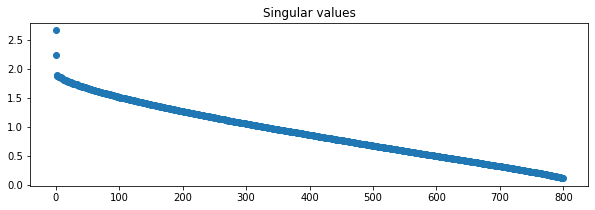

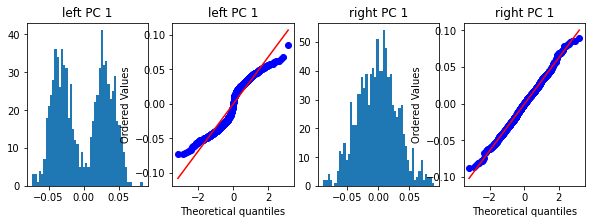

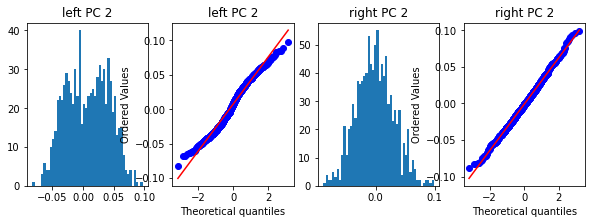

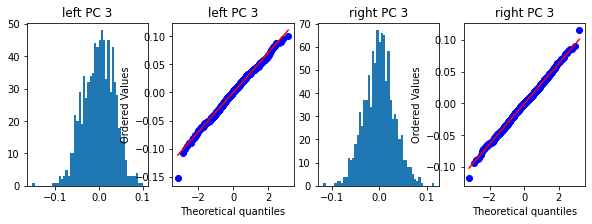

In [2]:
from ebpca.preprocessing import plot_pc
plot_pc(Y,nPCs=3, to_show=True, to_save=False)

As a result, only the top two stand out by looking at the signal value distribution of $Y$. The last one's singal strengh is too weak therefore covered by the noise. Accordingly, the left and the right PCs of the last component are both approximately Gaussian.

Therefore, we set the `rank` of algorithm to be 2.

### Step 1: EB-PCA

In [3]:
rank = 2

from ebpca import ebpca_gaussian
uest, vest = ebpca_gaussian(Y, rank)

s should be at least 0.9457 to satisfy the super critical condition.
Estimation of s is [2.24858612 1.68780986].


We compare EB-PCA's denoised PCs with sample PCs.

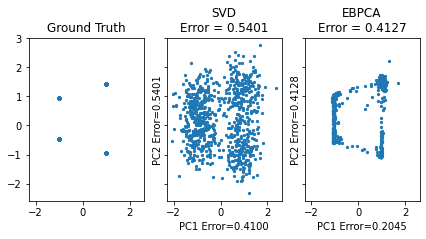

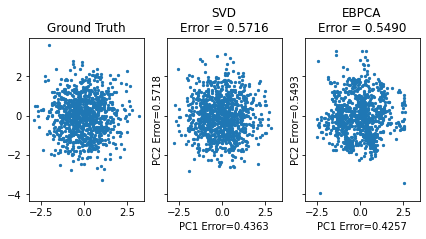

In [4]:
# Get sample PCs
U, _, Vh = np.linalg.svd(Y, full_matrices=False)
usvd = U[:,:2]
vsvd = Vh[:2,:].T 

from tutorial import compare_ebpca_with_svd
compare_ebpca_with_svd(Ustar, usvd, uest, to_show = True)
compare_ebpca_with_svd(Vstar, vsvd, vest, to_show = True)

We observe, EB-PCA improves substantially over sample PCs with there is strong prior structure of the ground truth. When the prior is not informative (i.e. jointly Gaussian), We can proved that SVD already gives the ''optimal'' estimate (up to scaling).

## Section II - Sophisticated features

This section explains the precedures of `ebpca_gaussian`, and introduce other useful features of `ebpca`.  

Revisiting the previous sample PCs diagnostic plots, we have the following observations:

As a result, only the top two stand out by looking at the signal value distribution of $Y$. The last one's singal strengh is too weak therefore covered by the noise. Accordingly, the left and the right PCs of the last component are both approximately Gaussian.

We also note there are distinct patterns for the left PCs, and the distribution of the right PCs are approximatly Gaussian. Our theory shows there is no additional gain by denoising the PC with Gaussian distribution from SVD.

Therefore, we set the `rank` of algorithm to be 2, and we will only denoise the left PCs.

### Step 1: PCA pack

We will normalize the data such that the noise level satisfy our model assumption, and in the mean time calculate the relevent parameters for EBPCA from observational matrix $Y_\textrm{obs}$. Some readers might wonder if the noise term satisfy our assumption. One way to do this is through checking whether the singular value distribution of the noise matrix satisfy MP law. See [MP law](https://en.wikipedia.org/wiki/Marchenko–Pastur_distribution).

s should be at least 0.9457 to satisfy the super critical condition.
Estimation of s is [2.24858612 1.68780986].


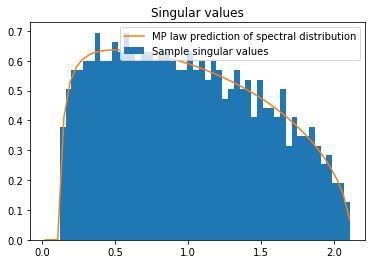

In [5]:
rank = 2 # By observing the data, we set rank to be 2.

# Normalize the observational matrix.
from ebpca.preprocessing import normalize_obs
from ebpca.pca import get_pca, check_residual_spectrum
X = normalize_obs(Y, rank)

# Prepare the PCA pack.
pcapack = get_pca(X, rank)

# Spectrum of the residual matrix (noise).
check_residual_spectrum(pcapack, to_show = True)

For real world data, most likely, the noise term doesn't exactly follow our assumption, and thus the MP law may not give such an accurate characterization of the residual matrix's spectrum. 

### Step 2: EBAMP 
#### Empirical Bayes method
User should first specfy the denoisers for the left and the right PCs. By default, they would be the non-parametric empirical Bayes estimator `NonparEB`. If users believes the prior can be parametrized by a parametric distribution family, they can implement their own estimator. 

For our current `NonparEB`, users can choose from two optimzers to solve the MLE problem--"Mosek" or "EM". "Mosek" use interior point method to solve this covex problem of NPMLE. If the users are not able to get the licence for *Mosek*, they can use *EM* by default.
In general, "Mosek"'s solution is closer to the optimal, but when the problem is large, say $n,d > 5000$, "Mosek" may take up too much time, and "EM" might be applied in this case.

Users can also set `nsupp_ratio` from 0 to 1, or `max_nsupp` to control the number of support points we sample from observations. They are set to be 1 and 2000 by default. Setting `max_nsupp = None` can remove this upper bound on the number of maximum support points. Reducing the number of support points will linearly improve the computational time. However, this may lose information on the scarce outlying samples.

#### AMP
Users should specify the number of amp iterations to run. AMP converges within several steps, and later iterations might amplify numerical errors, we highly recommend `amp_iters` to be less than 5. If users find the left PCs are approximately Gaussian, he is optional to turn that off by setting `muteu = True`. Mute denosing on the right PCs is the same by setting `mutev = True`.

In [6]:
# This is a practical application of ebpca.
from ebpca.empbayes import NonparEB
from ebpca.amp import ebamp_gaussian

udenoiser = NonparEB(optimizer = "EM", em_iter = 1000, nsupp_ratio = 1, max_nsupp = None)

# 
U, _ = ebamp_gaussian(pcapack, amp_iters=3, udenoiser=udenoiser, figprefix="tut", mutev = True)

# check for alignment along iterations
from tutorial import get_dist_of_subspaces
res = []
iters = U.shape[-1]
for i in range(iters):
    ans = get_dist_of_subspaces(U[:,:,i], Ustar, rank = 2)
    res.append(ans)
print("Error along iterations of U:")
print(res)

Error along iterations of U:
[0.5401215320730958, 0.427311715529326, 0.4185531809126157, 0.41181891143776334]


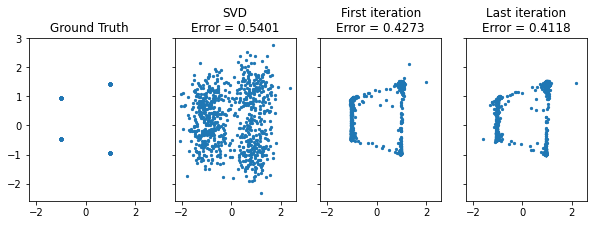

In [7]:
# Ustar is identified up to a flip sign.
from tutorial import redirect_pc
Ustar = redirect_pc(Ustar[:,:rank], pcapack.U)

from tutorial import compare_with_truth
compare_with_truth(Ustar, U, to_show=True)

We use the following example to show ebpca is denoising at the correct level of noise by plotting out the convolved density of the true prior with guassian with our estimated SNR $(M,\Sigma)$. We observe the distribution of the marginal is in correspondence with the density.

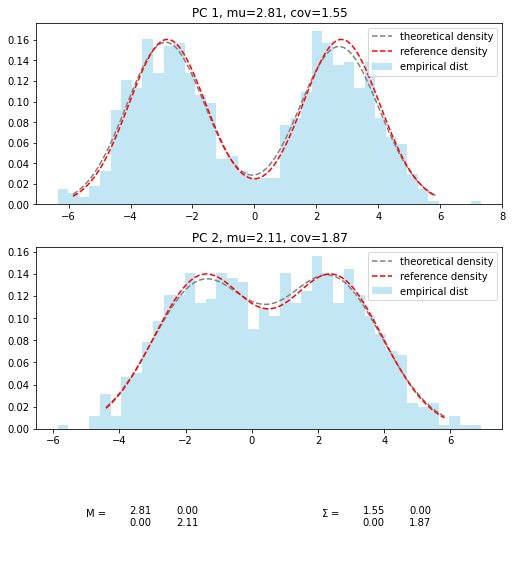

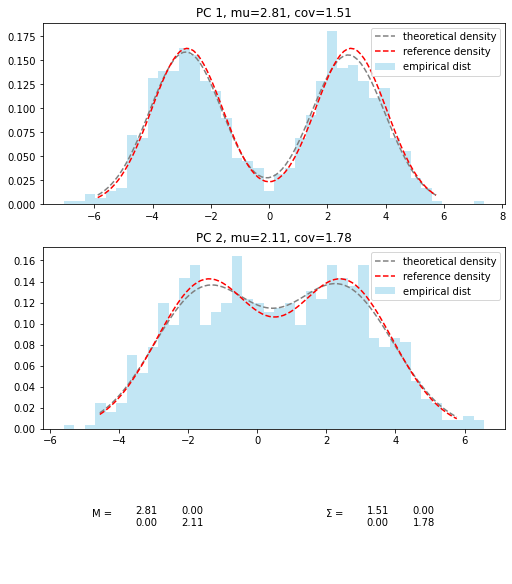

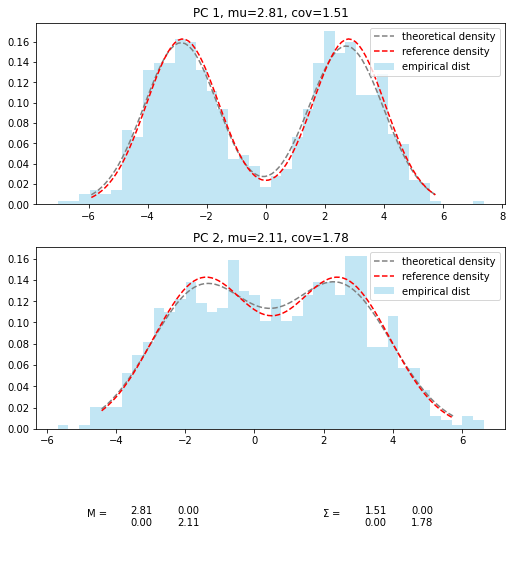

In [8]:
truePriorLoc = Ustar

from ebpca.empbayes import NonparEBChecker 
from ebpca.amp import ebamp_gaussian
from ebpca.empbayes import NonparEB

udenoiser = NonparEBChecker(truePriorLoc, optimizer ="EM", em_iter = 1000, to_show = True)
U, V = ebamp_gaussian(pcapack, amp_iters=3, udenoiser=udenoiser, mutev = True)